# Big Data Project
## Textile Defect Detection: Image Classification
The purpose of this project is to investigate how the different components of a Spark + Hadoop distributed environment interact in a distributed image classification task. We want to correctly assign **'good'** or **'defect'** labels to collected images of textile **patches**. 

The system **pipeline** is described as follows:


1.   Each machine in the distributed system collects textile images
2.   The images are uploaded to a Hadoop Distributed File System
3.   We use Spark to classify all images at request

The task we are implementing in this notebook concerns **Step 3**:


*   Convert dataset from h5 to png pictures
*   Create Train and Test splits
*   Train three simple models (**Approximate Similarity Join, K-Means, Bisecting K-Means**)
*   Evaluate the results through **F1 score**


We simulate the collection of images by uploading the TDD dataset directly to the HDFS.



In [5]:
# import the libraries
import os
import numpy as np
import h5py   # to manipulate the dataset as it's in `.h5` format
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Dataset

## Dataset Description

The dataset can be found at Kaggle - Textile Defect Detection (https://www.kaggle.com/datasets/belkhirnacim/textiledefectdetection). It has multiple formats: we choose to use the **72.000 images**, **64x64 resolution** h5 file. 

It contains 6 defect classes (color, good, cut, hole, metal contamination, thread), each having 12.000 images, but we are going to put all the defective classes together, ending up with 50.000 defective pictures in the class 'defect' and 12.000 images in the 'good' class (no defect). This operation is going to produce an **unbalanced** dataset, so we have to be careful in order to draw conclusions.

## Dataset Preprocessing (not distributed)

We need to convert the images from h5 format to png format. In an ideal envornment you would collect the pictures already in png format from the acquisition device. **This part is not ran on Spark** but it's just a data preprocessing step that is necessary to work with the chosen dataset. The code is left in this section for the sake of completion.

In [7]:
import tensorflow as tf    # used for creating tensors out of the dataset and training the model

# create an object that will take the dataset and produce the dataset in a format required for tensorflow dataset's API
class H5ToStorage:
  def __init__(self, hdf_path):
    self.path = hdf_path

    self.classes = []
    with h5py.File(self.path, 'r') as hf:
      for class_ in hf:
        self.classes.append(class_)

  # a generator to load the (img, class, angle)
  def generate_img_arr(self):
    for class_ in self.classes:
      with h5py.File(self.path, 'r') as hf:
        for angle in hf[class_]:
            for img in hf[class_][f"{angle}"]:
                yield img, class_, angle
  
  # utilize the generator to create new images and load it back to Storage
  def generate_train_dirs(self):
    # create the dataset's directories
    path = f"./dataset/train"

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data

        if label != 'good':
          label = 'defect'

        img_path = f"{path}/"+label+f"_{i}.png"
        plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle
    return metadata

In [8]:
!mkdir dataset
!mkdir dataset/train

In [9]:
# generate train data
train_gen = H5ToStorage("/content/matchingtDATASET_train_64.h5")
train_dict = train_gen.generate_train_dirs()

## Dataset Visualization

Now that all the images have been decompressed and saved as png pictures, let's see one patch sample:

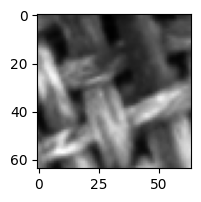

In [10]:
img = mpimg.imread('./dataset/train/defect_0.png')
plt.figure(figsize=[2,2])
plt.imshow(img)
plt.show()

This is a defective image. It is very likely that the defect class was **'color'**, since one region is significantly darker. 

Let's verify that the dataset is **unbalanced**:

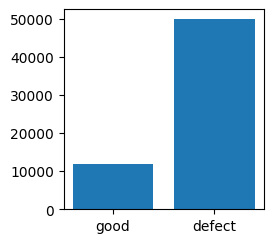

In [ ]:
import os

# folder path
dir_path = r'./dataset/train/'
good_count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)) and 'good' in path:
        good_count += 1

defect_count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)) and 'defect' in path:
        defect_count += 1

import matplotlib.pyplot as plt
fig = plt.figure(figsize=[2,2])
ax = fig.add_axes([0,0,1,1])
langs = ['good', 'defect']
students = [good_count, defect_count]
ax.bar(langs,students)
plt.show()

## Baseline results

In order to draw conclusions on the test set evaluation, we first calculate the baseline F1 results for some 'random' or 'untrained' classifiers, so that we can tell the magnitude of the improvement. We call **r** the fraction of good samples (1/6).

- **Random classifier** (classes assigned with same probability 0.5): the precision simplifies to *r*, and the recall simplifies to 0.5. In this case, the F1-score is: $\frac{2\times 0.5\times r}{0.5+r}$, which is **0.25**

- **Always true classifier**: The precision simplifies to *r*
 and the recall is obviously 1. Thus, F1-score is $\frac{2\times r}{1+r}$, which is roughly **0.28**

Therefore, improving from these results will show that our models are training correctly, and comparing their **F1 score** tells us which ones behaves better.

# Spark Session

We are going to use PySpark MLlib for the machine learning algorithms.

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.sql.functions import avg, col, concat, desc, lit, min, max, split, udf, countDistinct, sum, count
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import Window
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit

In [ ]:
# for cluster mode
"""
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("sparkify").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "5120m").\
        getOrCreate()
"""

In [ ]:
# for local mode
spark = SparkSession.builder.getOrCreate()

# Dataset Loading

In [ ]:
df = spark.read.format("image").load("./dataset/train")

After creating the Spark session and reading the dataset, we want to convert the images to UDT vectors, in order to have them as input to the ML models. We also prepare the 'features' column as expected by the K-Means algorithms, and the 'id' column expected by ANN.

In [ ]:
img2vec = F.udf(lambda x: DenseVector(x['data']), VectorUDT())
df = df.withColumn('features', img2vec("image"))
df = df.withColumn('id', df['image'])

And then we take a random split for the train and test images.

In [ ]:
train_df, test_df = df.randomSplit([0.6, 0.4], 28)

# Approximate Similarity Join

Approximate similarity join takes two datasets and approximately returns pairs of rows in the datasets whose **distance is smaller** than a user-defined threshold. 

**Bucketed Random Projection** is an LSH family for Euclidean distance. The general idea of LSH is to use a family of functions (“LSH families”) to hash data points into buckets, so that the data points which are close to each other are in the same buckets with **high probability**, while data points that are far away from each other are very likely in different buckets.

In this case the threshold is set at the highest possible distance we can find: since images are 64x64 with 3 channels, the maximum Euclidean distance between to pictures is $\sqrt{256^2\times 64^2 \times 3} ≈ 28378$.

In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", bucketLength=2.0,
                                  numHashTables=3)
model = brp.fit(train_df)

# Feature Transformation
print("The hashed dataset where hashed values are stored in the column 'hashes':")
model.transform(train_df).show()

# Compute the locality sensitive hashes for the input rows, then perform approximate
# similarity join.
# We could avoid computing hashes by passing in the already-transformed dataset, e.g.
# `model.approxSimilarityJoin(transformedA, transformedB, 1.5)`
res = model.approxSimilarityJoin(train_df, test_df, 28378, distCol="EuclideanDistance")\
    .select(col("datasetA.id").alias("idA"),
            col("datasetB.id").alias("idB"),
            col("datasetA.features").alias("idAf"),
            col("datasetB.features").alias("idBf"),
            col("EuclideanDistance"))

The hashed dataset where hashed values are stored in the column 'hashes':
+--------------------+--------------------+--------------------+--------------------+
|               image|            features|                  id|              hashes|
+--------------------+--------------------+--------------------+--------------------+
|{file:///content/...|[130.0,130.0,130....|{file:///content/...|[[14.0], [72.0], ...|
|{file:///content/...|[78.0,78.0,78.0,2...|{file:///content/...|[[0.0], [26.0], [...|
|{file:///content/...|[187.0,187.0,187....|{file:///content/...|[[-4.0], [59.0], ...|
|{file:///content/...|[186.0,186.0,186....|{file:///content/...|[[-10.0], [50.0],...|
|{file:///content/...|[130.0,130.0,130....|{file:///content/...|[[14.0], [72.0], ...|
|{file:///content/...|[186.0,186.0,186....|{file:///content/...|[[-10.0], [50.0],...|
|{file:///content/...|[130.0,130.0,130....|{file:///content/...|[[14.0], [72.0], ...|
|{file:///content/...|[78.0,78.0,78.0,2...|{file:///content/...|[[

In [ ]:
collected = res.collect()

In [11]:
f1_scores = [0,0,0,0]

for i in collected:
  if 'good' in i[1].origin and 'good' in i[0].origin:
    f1_scores[0] += 1 # tp
  if 'good' in i[1].origin and 'defect' in i[0].origin:
    f1_scores[1] += 1 # fn
  if 'defect' in i[1].origin and 'good' in i[0].origin:
    f1_scores[2] += 1 # fp
  if 'defect' in i[1].origin and 'defect' in i[0].origin:
    f1_scores[3] += 1 # tn

print('f1 score',f1_scores[0]/(f1_scores[0]+0.5*(f1_scores[1]+f1_scores[2])))

f1 score 0.23404255319148937


# K-means

Let's now test a more robust approach: **clustering**. We expect the results to improve since now we are not comparing testing samples with the training samples one by one but with an entire cluster. 

There's a slight difference with the previous approach: this one is **unsupervised**. We *accept as hypothesis* that the two clusters found correspond to 'good' and 'defect' labels. There are two ways to choose which one is which, so are going to go with the choice that **maximizes the F1**, expecting the opposite choice to give a very low score.

In [ ]:
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(train_df)

In [ ]:
# Make predictions
pred_df = model.transform(test_df).toPandas()

In [ ]:
f1_scores = [0,0,0,0]

for i in pred_df.iloc:
  if 'good' in i.image.origin and i.prediction==1:
    f1_scores[0] += 1 # tp
  if 'good' in i.image.origin and i.prediction==0:
    f1_scores[1] += 1 # fn
  if 'defect' in i.image.origin and i.prediction==1:
    f1_scores[2] += 1 # fp
  if 'defect' in i.image.origin and i.prediction==0:
    f1_scores[3] += 1 # tn

f11 = f1_scores[0]/(f1_scores[0]+0.5*(f1_scores[1]+f1_scores[2]))

f1_scores = [0,0,0,0]

for i in pred_df.iloc:
  if 'good' in i.image.origin and i.prediction==0:
    f1_scores[0] += 1 # tp
  if 'good' in i.image.origin and i.prediction==1:
    f1_scores[1] += 1 # fn
  if 'defect' in i.image.origin and i.prediction==0:
    f1_scores[2] += 1 # fp
  if 'defect' in i.image.origin and i.prediction==1:
    f1_scores[3] += 1 # tn

f12 = f1_scores[0]/(f1_scores[0]+0.5*(f1_scores[1]+f1_scores[2]))
f1s = [f11,f12]
print('f1 score',np.max(f1s))

f1 score 0.41025641025641024


# Bisecting K-means

As alternative ML algorithm, we also want to test Bisecting K-Means. 

Bisecting k-means is a kind of **hierarchical** clustering using a divisive (or “top-down”) approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.

Bisecting K-means can often be much **faster** than regular K-means, but it will generally produce a **different clustering**.

In [ ]:
from pyspark.ml.clustering import BisectingKMeans

# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(2).setSeed(1)
model = bkm.fit(train_df)

# Make predictions
pred_df = model.transform(test_df).toPandas()

In [ ]:
f1_scores = [0,0,0,0]

for i in pred_df.iloc:
  if 'good' in i.image.origin and i.prediction==1:
    f1_scores[0] += 1 # tp
  if 'good' in i.image.origin and i.prediction==0:
    f1_scores[1] += 1 # fn
  if 'defect' in i.image.origin and i.prediction==1:
    f1_scores[2] += 1 # fp
  if 'defect' in i.image.origin and i.prediction==0:
    f1_scores[3] += 1 # tn

f11 = f1_scores[0]/(f1_scores[0]+0.5*(f1_scores[1]+f1_scores[2]))

f1_scores = [0,0,0,0]

for i in pred_df.iloc:
  if 'good' in i.image.origin and i.prediction==0:
    f1_scores[0] += 1 # tp
  if 'good' in i.image.origin and i.prediction==1:
    f1_scores[1] += 1 # fn
  if 'defect' in i.image.origin and i.prediction==0:
    f1_scores[2] += 1 # fp
  if 'defect' in i.image.origin and i.prediction==1:
    f1_scores[3] += 1 # tn

f12 = f1_scores[0]/(f1_scores[0]+0.5*(f1_scores[1]+f1_scores[2]))
f1s = [f11,f12]
print('f1 score',np.max(f1s))

f1 score 0.4536082474226804
